### Comparative Analysis of Machine Learning Algorithms along with Classifiers for Network Intrusion Detection 
###                                                                     Implementation Using Python

Our presentation [Classifier Comparison for Network Intrusion Detection](https://docs.google.com/presentation/d/1V_9YHwZyugLXE-bfEkRIg-UN4kwvc4v9g9FRCuz_qmA/edit?usp=sharing)

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np
import time

from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn import metrics
import ggplot
from ggplot import aes
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

#### Sourcing Data

The NSL-KDD dataset referenced in the paper was not accessible. The site referenced is not active anymore. Lot of searching on the web, ended in finding a [dataset](https://web.archive.org/web/20150412064436/http://nsl.cs.unb.ca/NSL-KDD/) whose shape is same as what is mentioned in the paper, with respect to number of features, but the number of records were quite different. 

The data files were in ARFF format. This format is native a tool called Weka. Few python libraries were tried to convert this in python readable format, but all of them resulted in different types of errors.

So as a workaround used 'R' library 'RIO' to make the conversion.


<b>library('rio')<br>
convert("KDDTest+.arff","KDDTest.csv")<br>
convert("KDDTrain+.arff","KDDTrain.csv")</b>


#### Reading Data

In [2]:
#reading training and test set
train = pd.read_csv("KDDTrain.csv")
test = pd.read_csv("KDDTest.csv")

In [3]:
print('Dimensions of Training Set ',train.shape)
print('Dimensions of Test Set ',test.shape)

Dimensions of Training Set  (125973, 42)
Dimensions of Test Set  (22544, 42)


In [4]:
#first 5 records from training set
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


#### Data Cleansing

From the above preview, it is evident that some of the features are of String type. SKLearn Classifiers such as decision tree and Random Forests do not accept string types. In order to over come this problem, such features are identified and encoded into numeric types.

In [5]:
#to find string features
df_train_str = train.select_dtypes(include=[object])

In [6]:
#print fields that in string format
str_fld_list = list(df_train_str.columns)
str_fld_list

['protocol_type', 'service', 'flag', 'class']

In [7]:
from sklearn.preprocessing import LabelEncoder

#encoding train
train_encode_dict = {}
train_conv_feat_dict = {}
for feat in str_fld_list:
    le = LabelEncoder()
    le.fit(df_train_str[feat])
    
    #storing encode model for future decode
    train_encode_dict[feat] = le
    train_conv_feat_dict[feat] = le.transform(df_train_str[feat])


for feat in str_fld_list:
    a = train_encode_dict[feat]
    print(a.classes_)

for feat in str_fld_list:
    a = train_conv_feat_dict[feat]
    print(a)   
    
    
#now adding the transformed field into the df

for feat in str_fld_list:
    del train[feat]
    train[feat] = train_conv_feat_dict[feat]



['icmp' 'tcp' 'udp']
['IRC' 'X11' 'Z39_50' 'aol' 'auth' 'bgp' 'courier' 'csnet_ns' 'ctf'
 'daytime' 'discard' 'domain' 'domain_u' 'echo' 'eco_i' 'ecr_i' 'efs'
 'exec' 'finger' 'ftp' 'ftp_data' 'gopher' 'harvest' 'hostnames' 'http'
 'http_2784' 'http_443' 'http_8001' 'imap4' 'iso_tsap' 'klogin' 'kshell'
 'ldap' 'link' 'login' 'mtp' 'name' 'netbios_dgm' 'netbios_ns'
 'netbios_ssn' 'netstat' 'nnsp' 'nntp' 'ntp_u' 'other' 'pm_dump' 'pop_2'
 'pop_3' 'printer' 'private' 'red_i' 'remote_job' 'rje' 'shell' 'smtp'
 'sql_net' 'ssh' 'sunrpc' 'supdup' 'systat' 'telnet' 'tftp_u' 'tim_i'
 'time' 'urh_i' 'urp_i' 'uucp' 'uucp_path' 'vmnet' 'whois']
['OTH' 'REJ' 'RSTO' 'RSTOS0' 'RSTR' 'S0' 'S1' 'S2' 'S3' 'SF' 'SH']
['anomaly' 'normal']
[1 2 1 ..., 1 1 1]
[20 44 49 ..., 54 30 20]
[9 9 5 ..., 9 5 9]
[1 1 0 ..., 1 0 1]


In [8]:
#similarly processing Test data set
df_test_str = test.select_dtypes(include=[object])

#print fields that in string format
str_fld_list = list(df_test_str.columns)
str_fld_list

#encoding test
test_encode_dict = {}
test_conv_feat_dict = {}
for feat in str_fld_list:
    le = LabelEncoder()
    le.fit(df_test_str[feat])
    
    #storing encode model for future decode
    test_encode_dict[feat] = le
    test_conv_feat_dict[feat] = le.transform(df_test_str[feat])


for feat in str_fld_list:
    a = test_encode_dict[feat]
    print(a.classes_)

for feat in str_fld_list:
    a = test_conv_feat_dict[feat]
    print(a)   
    
    
#now adding the transformed field into the df

for feat in str_fld_list:
    del test[feat]
    test[feat] = test_conv_feat_dict[feat]



['icmp' 'tcp' 'udp']
['IRC' 'X11' 'Z39_50' 'auth' 'bgp' 'courier' 'csnet_ns' 'ctf' 'daytime'
 'discard' 'domain' 'domain_u' 'echo' 'eco_i' 'ecr_i' 'efs' 'exec' 'finger'
 'ftp' 'ftp_data' 'gopher' 'hostnames' 'http' 'http_443' 'imap4' 'iso_tsap'
 'klogin' 'kshell' 'ldap' 'link' 'login' 'mtp' 'name' 'netbios_dgm'
 'netbios_ns' 'netbios_ssn' 'netstat' 'nnsp' 'nntp' 'ntp_u' 'other'
 'pm_dump' 'pop_2' 'pop_3' 'printer' 'private' 'remote_job' 'rje' 'shell'
 'smtp' 'sql_net' 'ssh' 'sunrpc' 'supdup' 'systat' 'telnet' 'tftp_u'
 'tim_i' 'time' 'urp_i' 'uucp' 'uucp_path' 'vmnet' 'whois']
['OTH' 'REJ' 'RSTO' 'RSTOS0' 'RSTR' 'S0' 'S1' 'S2' 'S3' 'SF' 'SH']
['anomaly' 'normal']
[1 1 1 ..., 1 2 1]
[45 45 19 ..., 22 11 52]
[1 1 9 ..., 9 9 1]
[0 0 1 ..., 0 1 0]


In [9]:
#Transformed Train Set - Preview
train.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type,service,flag,class
0,0,491,0,0,0,0,0,0,0,0,...,0.17,0.00,0.00,0.00,0.05,0.00,1,20,9,1
1,0,146,0,0,0,0,0,0,0,0,...,0.88,0.00,0.00,0.00,0.00,0.00,2,44,9,1
2,0,0,0,0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.00,0.00,1,49,5,0
3,0,232,8153,0,0,0,0,0,1,0,...,0.03,0.04,0.03,0.01,0.00,0.01,1,24,9,1
4,0,199,420,0,0,0,0,0,1,0,...,0.00,0.00,0.00,0.00,0.00,0.00,1,24,9,1


In [10]:
#Transformed Test Set - Preview
test.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type,service,flag,class
0,0,0,0,0,0,0,0,0,0,0,...,0.00,0.00,0.0,0.0,1.00,1.00,1,45,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0.00,0.00,0.0,0.0,1.00,1.00,1,45,1,0
2,2,12983,0,0,0,0,0,0,0,0,...,0.61,0.02,0.0,0.0,0.00,0.00,1,19,9,1
3,0,20,0,0,0,0,0,0,0,0,...,1.00,0.28,0.0,0.0,0.00,0.00,0,13,9,0
4,1,0,15,0,0,0,0,0,0,0,...,0.03,0.02,0.0,0.0,0.83,0.71,1,55,2,0


In [11]:
#splitting df into features and predicted value
y_train = train['class']
X_train = train.copy()
del X_train['class']


y_test = test['class']
X_test = test.copy()
del X_test['class']

In [12]:
#If we just assumed everything to an anomaly, then our accuracy would be as follows
np.mean(y_test)

0.43075762952448543

### Various Classifiers : Training and Testing

In [13]:
#initializing list to hold stats from various classifiers
classifier_list = []

#### 1. Logistic Classifier

##### Training/Testing using default setting

In [14]:
logistic = linear_model.LogisticRegression()
logistic.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [15]:
#accuracy
log_acr = sum(logistic.predict(X_test)==y_test)/y_test.shape[0]
print('Accuracy for Logistic Classfier(Default parameters)',log_acr)

Accuracy for Logistic Classfier(Default parameters) 0.683552164656


##### Training/Testing using 10 fold CVV and grid search through various parameters

In [16]:

log_start_time = time.clock()
clfl2=linear_model.LogisticRegression()
parameters = {"C": [0.0001, 0.001, 0.1, 1, 10, 100]}
log_fitmodel = GridSearchCV(clfl2, param_grid=parameters, cv=10, scoring="accuracy")
log_fitmodel.fit(X_train, y_train)

print('CV Best Estimator \n',log_fitmodel.best_estimator_)
print('CV Best Params \n',log_fitmodel.best_params_)
print('CV Best Accuracy Score \n',log_fitmodel.best_score_)##, fitmodel.grid_scores_

log_end_time = time.clock()
log_training_time = log_end_time - log_start_time
print('Training Time : ', log_training_time)

CV Best Estimator 
 LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
CV Best Params 
 {'C': 0.0001}
CV Best Accuracy Score 
 0.877370547657
Training Time :  303.788412


In [17]:
clfl2=linear_model.LogisticRegression(C=log_fitmodel.best_params_['C'])
clfl2.fit(X_train, y_train)
log_ypred2=clfl2.predict(X_test)
log_acr = accuracy_score(log_ypred2, y_test)
print('Accuracy Score on Test Set',log_acr)

Accuracy Score on Test Set 0.68390702626


In [18]:
log_preds = clfl2.predict_proba(X_test)[:,1]
log_fpr, log_tpr, _ = metrics.roc_curve(y_test, log_preds)
log_sens = np.mean(log_tpr)

log_auc = metrics.auc(log_fpr, log_tpr)

log_dict = dict(classifier_name='Logistic',accuracy=log_acr,AUC=log_auc,sensitivity=log_sens,training_time=log_training_time)
classifier_list.append(log_dict)
pd.DataFrame(classifier_list,columns=['classifier_name','accuracy','AUC','sensitivity','training_time'])

,classifier_name,accuracy,AUC,sensitivity,training_time
0,Logistic,0.683907,0.869224,0.754556,303.788412


In [19]:
#function to plot ROC Curve
def plot_chart(fpr,tpr,auc,name,ax=None):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    
    ax.plot(fpr, tpr, '.-', alpha=0.3, markersize=4, label='ROC curve for %s (area = %0.2f)' % (name, auc))
    
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    
    return ax


    

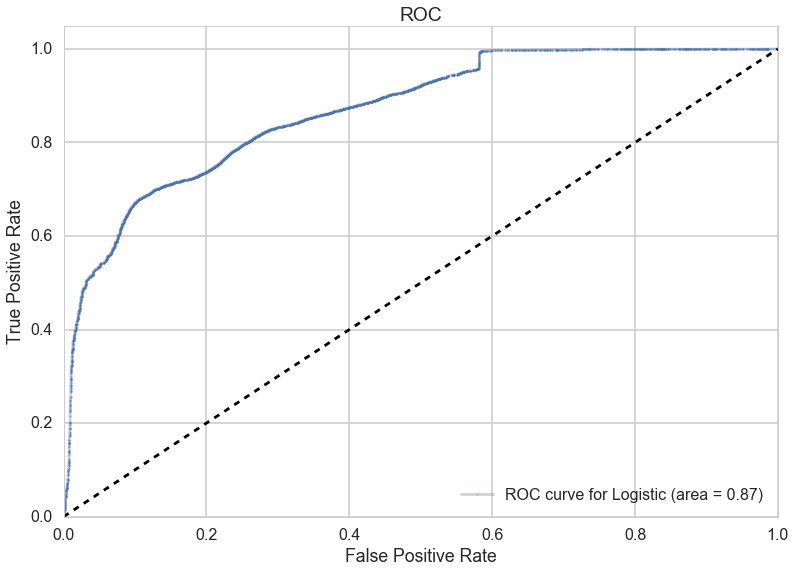

In [20]:
#ROC Curve
name = 'Logistic'
ax = plot_chart(log_fpr,log_tpr,log_auc,name,None)
#plot_chart(dt_fpr,dt_tpr,dt_auc,name,ax)

#### 2. Decision Trees

##### Training/Testing using default setting

In [21]:
from sklearn import tree
part = tree.DecisionTreeClassifier()
part.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [22]:
#accuracy
part_acr = sum(part.predict(X_test)==y_test)/y_test.shape[0]
print('Accuracy for Logistic Classfier(Default parameters)',part_acr)

Accuracy for Logistic Classfier(Default parameters) 0.780207594038


##### Training/Testing using 10 fold CVV and grid search through various parameters

In [23]:
dt_start_time = time.clock()
clfl3 = tree.DecisionTreeClassifier()
parameters = {"criterion": ['gini','entropy'],'min_samples_split':[2,10,50,100],'splitter':['best','random']}
dt_fitmodel = GridSearchCV(clfl3, param_grid=parameters, cv=10, scoring="accuracy")
dt_fitmodel.fit(X_train, y_train)
print('CV Best Estimator \n',dt_fitmodel.best_estimator_)
print('CV Best Params \n',dt_fitmodel.best_params_)
print('CV Best Accuracy Score \n',dt_fitmodel.best_score_)##, fitmodel.grid_scores_

dt_end_time = time.clock()
dt_training_time = dt_end_time - dt_start_time
print('Training Time : ', dt_training_time)

CV Best Estimator 
 DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
CV Best Params 
 {'criterion': 'entropy', 'splitter': 'best', 'min_samples_split': 2}
CV Best Accuracy Score 
 0.998317099696
Training Time :  95.28564599999999


In [24]:
clfl3=tree.DecisionTreeClassifier(criterion=dt_fitmodel.best_params_['criterion'],min_samples_split=dt_fitmodel.best_params_['min_samples_split'],splitter=dt_fitmodel.best_params_['splitter'])
clfl3.fit(X_train, y_train)
dt_ypred2=clfl3.predict(X_test)
dt_acr = accuracy_score(dt_ypred2, y_test)
print('Accuracy Score on Test Set',dt_acr)

Accuracy Score on Test Set 0.801410574876


In [25]:
dt_preds = clfl3.predict_proba(X_test)[:,1]
dt_fpr, dt_tpr, _ = metrics.roc_curve(y_test, dt_preds)
dt_sens = np.mean(dt_tpr)

dt_auc = metrics.auc(dt_fpr, dt_tpr)

dt_dict = dict(classifier_name='Decision Tree',accuracy=dt_acr,AUC=dt_auc,sensitivity=dt_sens,training_time=dt_training_time)
classifier_list.append(dt_dict)
pd.DataFrame(classifier_list,columns=['classifier_name','accuracy','AUC','sensitivity','training_time'])

,classifier_name,accuracy,AUC,sensitivity,training_time
0,Logistic,0.683907,0.869224,0.754556,303.788412
1,Decision Tree,0.801411,0.821771,0.734554,95.285646


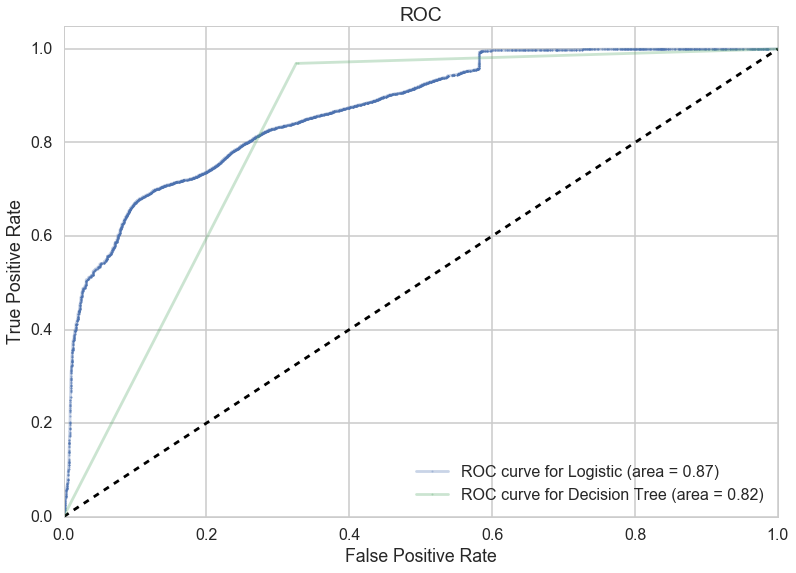

In [26]:
#ROC Curve

name = 'Logistic'
ax = plot_chart(log_fpr,log_tpr,log_auc,name,None)
name = 'Decision Tree'
plot_chart(dt_fpr,dt_tpr,dt_auc,name,ax)

#### 3. Naive Bayes

##### Training/Testing using default setting

In [27]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [28]:
#accuracy
gnb_acr = sum(gnb.predict(X_test)==y_test)/y_test.shape[0]
print('Accuracy for Naive Bayes Classfier(Default parameters)',gnb_acr)

Accuracy for Naive Bayes Classfier(Default parameters) 0.450319375444


##### Training/Testing using 10 fold CVV and grid search through various parameters

In [29]:
nb_start_time = time.clock()
clfl4 = GaussianNB()
parameters = {}
nb_fitmodel = GridSearchCV(clfl4, param_grid=parameters, cv=10, scoring="accuracy")
nb_fitmodel.fit(X_train, y_train)
print('CV Best Estimator \n',nb_fitmodel.best_estimator_)
print('CV Best Params \n',nb_fitmodel.best_params_)
print('CV Best Accuracy Score \n',nb_fitmodel.best_score_)##, fitmodel.grid_scores_

nb_end_time = time.clock()
nb_training_time = nb_end_time - nb_start_time
print('Training Time : ', nb_training_time)

CV Best Estimator 
 GaussianNB()
CV Best Params 
 {}
CV Best Accuracy Score 
 0.534193835187
Training Time :  3.126060999999993


In [30]:
clfl4= GaussianNB()
clfl4.fit(X_train, y_train)
nb_ypred=clfl4.predict(X_test)
nb_acr = accuracy_score(nb_ypred, y_test)
print('Accuracy Score on Test Set',nb_acr)

Accuracy Score on Test Set 0.450319375444


In [31]:
nb_preds = clfl4.predict_proba(X_test)[:,1]
nb_fpr, nb_tpr, _ = metrics.roc_curve(y_test, nb_preds)
nb_sens = np.mean(nb_tpr)

nb_auc = metrics.auc(nb_fpr, nb_tpr)

nv_dict = dict(classifier_name='Naive Bayes',accuracy=nb_acr,AUC=nb_auc,sensitivity=nb_sens,training_time=nb_training_time)
classifier_list.append(nv_dict)
pd.DataFrame(classifier_list,columns=['classifier_name','accuracy','AUC','sensitivity','training_time'])

,classifier_name,accuracy,AUC,sensitivity,training_time
0,Logistic,0.683907,0.869224,0.754556,303.788412
1,Decision Tree,0.801411,0.821771,0.734554,95.285646
2,Naive Bayes,0.450319,0.866243,0.802669,3.126061


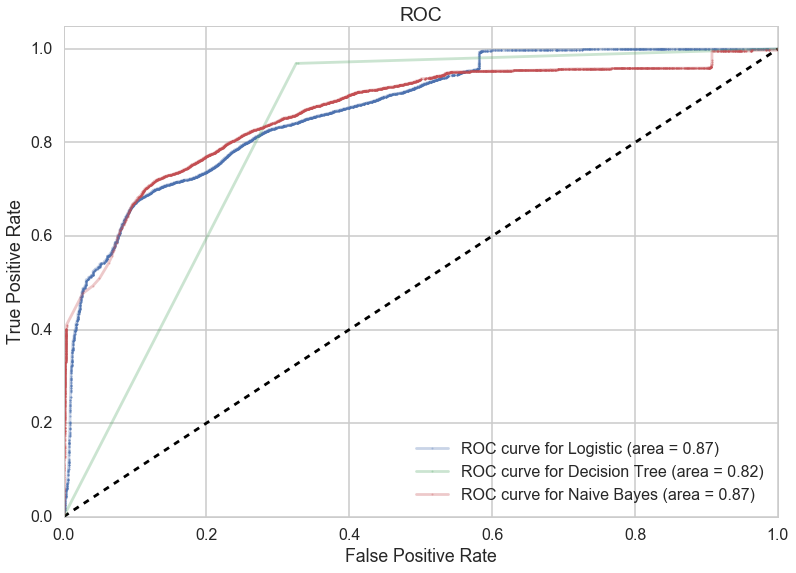

In [32]:
#ROC Curve

name = 'Logistic'
ax = plot_chart(log_fpr,log_tpr,log_auc,name,None)
name = 'Decision Tree'
plot_chart(dt_fpr,dt_tpr,dt_auc,name,ax)
name = 'Naive Bayes'
plot_chart(nb_fpr,nb_tpr,nb_auc,name,ax)

#### 4. Random Forest

##### Training/Testing using default setting

In [33]:
from sklearn.ensemble import RandomForestClassifier

rf= RandomForestClassifier(n_estimators=25)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [34]:
#accuracy
f_acr = sum(rf.predict(X_test)==y_test)/y_test.shape[0]
print('Accuracy for Naive Bayes Classfier(Default parameters)',f_acr)

Accuracy for Naive Bayes Classfier(Default parameters) 0.768364088006


##### Training/Testing using 10 fold CVV and grid search through various parameters

In [35]:
rf_start_time = time.clock()
clfl5 = RandomForestClassifier()
parameters = {"n_estimators": [5,10,20,25,50,100],'criterion':['gini','entropy'],'min_samples_split':[2,10,50,100]}
rf_fitmodel = GridSearchCV(clfl5, param_grid=parameters, cv=10, scoring="accuracy")
rf_fitmodel.fit(X_train, y_train)
print('CV Best Estimator \n',rf_fitmodel.best_estimator_)
print('CV Best Params \n',rf_fitmodel.best_params_)
print('CV Best Accuracy Score \n',rf_fitmodel.best_score_)##, fitmodel.grid_scores_

rf_end_time = time.clock()
rf_training_time = rf_end_time - rf_start_time
print('Training Time : ', rf_training_time)

CV Best Estimator 
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
CV Best Params 
 {'n_estimators': 50, 'criterion': 'gini', 'min_samples_split': 2}
CV Best Accuracy Score 
 0.998999785668
Training Time :  1356.148891


In [36]:
clfl5=RandomForestClassifier(criterion=rf_fitmodel.best_params_['criterion'],min_samples_split=rf_fitmodel.best_params_['min_samples_split'],n_estimators=rf_fitmodel.best_params_['n_estimators'])
clfl5.fit(X_train, y_train)
rf_ypred=clfl5.predict(X_test)
rf_acr = accuracy_score(rf_ypred, y_test)
print('Accuracy Score on Test Set',rf_acr)

Accuracy Score on Test Set 0.776525904897


In [37]:
rf_preds = clfl5.predict_proba(X_test)[:,1]
rf_fpr, rf_tpr, _ = metrics.roc_curve(y_test, rf_preds)
rf_sens = np.mean(rf_tpr)

rf_auc = metrics.auc(rf_fpr, rf_tpr)

rf_dict = dict(classifier_name='Random Forests',accuracy=rf_acr,AUC=rf_auc,sensitivity=rf_sens,training_time=rf_training_time)
classifier_list.append(rf_dict)
pd.DataFrame(classifier_list,columns=['classifier_name','accuracy','AUC','sensitivity','training_time'])

,classifier_name,accuracy,AUC,sensitivity,training_time
0,Logistic,0.683907,0.869224,0.754556,303.788412
1,Decision Tree,0.801411,0.821771,0.734554,95.285646
2,Naive Bayes,0.450319,0.866243,0.802669,3.126061
3,Random Forests,0.776526,0.912739,0.914546,1356.148891


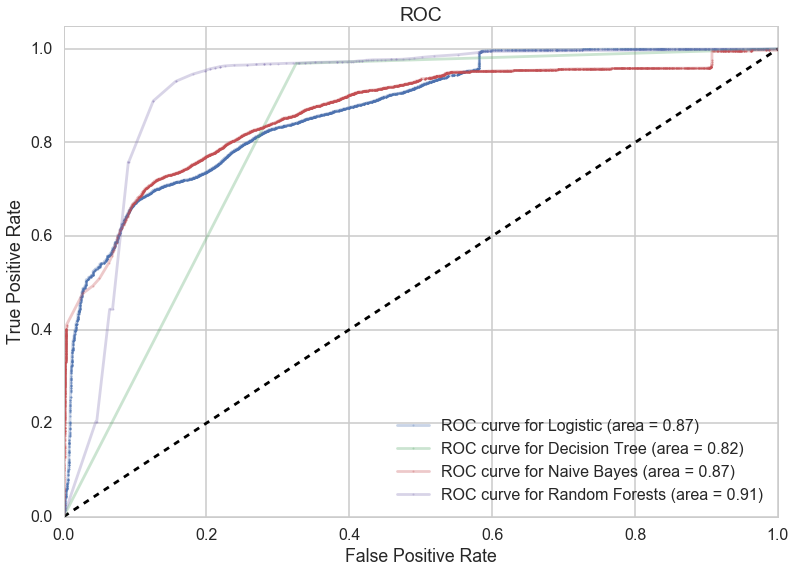

In [38]:
#ROC Curve

name = 'Logistic'
ax = plot_chart(log_fpr,log_tpr,log_auc,name,None)
name = 'Decision Tree'
plot_chart(dt_fpr,dt_tpr,dt_auc,name,ax)
name = 'Naive Bayes'
plot_chart(nb_fpr,nb_tpr,nb_auc,name,ax)
name = 'Random Forests'
plot_chart(rf_fpr,rf_tpr,rf_auc,name,ax)

#### 6. Ensemble Method - AdaBoost

##### Training/Testing using default setting

In [39]:
from sklearn.ensemble import AdaBoostClassifier

boost = AdaBoostClassifier()
boost.fit(X_train, y_train)

#accuracy
boost_acr = sum(boost.predict(X_test)==y_test)/y_test.shape[0]
print('Accuracy for AdaBoost Classfier(Default parameters)',boost_acr)

Accuracy for AdaBoost Classfier(Default parameters) 0.779586586231


##### Training/Testing using 10 fold CVV and grid search through various parameters

In [40]:
boost_start_time = time.clock()
clfl6=AdaBoostClassifier()
parameters = {"n_estimators": [10,20,30]}
boost_fitmodel = GridSearchCV(clfl6, param_grid=parameters, cv=10, scoring="accuracy")
boost_fitmodel.fit(X_train, y_train)
print('CV Best Estimator \n',boost_fitmodel.best_estimator_)
print('CV Best Params \n',boost_fitmodel.best_params_)
print('CV Best Accuracy Score \n',boost_fitmodel.best_score_)##, fitmodel.grid_scores_

boost_end_time = time.clock()
boost_training_time = boost_end_time - boost_start_time
print('Training Time(s) : ', boost_training_time)


CV Best Estimator 
 AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=30, random_state=None)
CV Best Params 
 {'n_estimators': 30}
CV Best Accuracy Score 
 0.982258102927
Training Time(s) :  62.17044099999998


In [41]:
#AdaBoost Test
clfl6 = AdaBoostClassifier(n_estimators=boost_fitmodel.best_params_['n_estimators'])
clfl6.fit(X_train, y_train)
boost_ypred2=clfl6.predict(X_test)
boost_acr = accuracy_score(boost_ypred2, y_test)
print('Accuracy Score on Test Set',boost_acr)


Accuracy Score on Test Set 0.787970191625


In [42]:

boost_preds = clfl6.predict_proba(X_test)[:,1]
boost_fpr, boost_tpr, _ = metrics.roc_curve(y_test, boost_preds)
boost_sens = np.mean(boost_tpr)

boost_auc = metrics.auc(boost_fpr, boost_tpr)

boost_dict = dict(classifier_name='AdaBoost',accuracy=boost_acr,AUC=boost_auc,sensitivity=boost_sens,training_time=boost_training_time)
classifier_list.append(boost_dict)
pd.DataFrame(classifier_list,columns=['classifier_name','accuracy','AUC','sensitivity','training_time'])

,classifier_name,accuracy,AUC,sensitivity,training_time
0,Logistic,0.683907,0.869224,0.754556,303.788412
1,Decision Tree,0.801411,0.821771,0.734554,95.285646
2,Naive Bayes,0.450319,0.866243,0.802669,3.126061
3,Random Forests,0.776526,0.912739,0.914546,1356.148891
4,AdaBoost,0.787970,0.938450,0.852644,62.170441


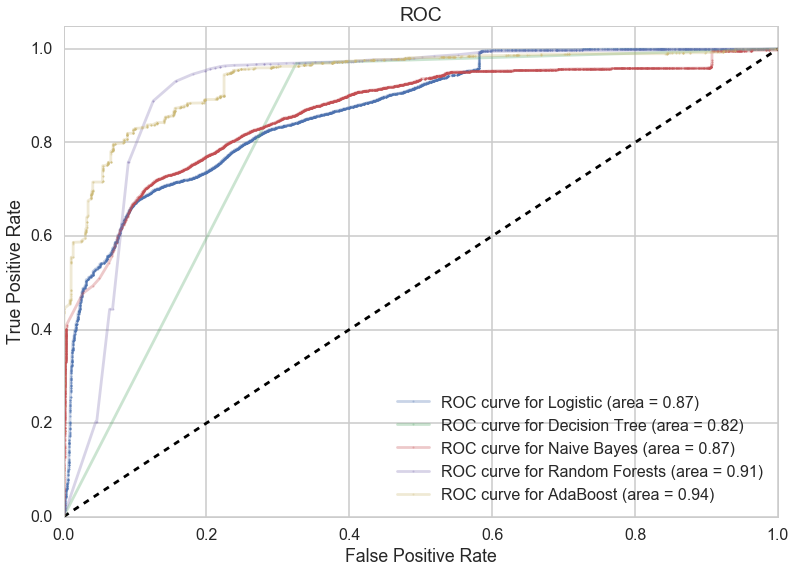

In [43]:
#ROC Curve

name = 'Logistic'
ax = plot_chart(log_fpr,log_tpr,log_auc,name,None)
name = 'Decision Tree'
plot_chart(dt_fpr,dt_tpr,dt_auc,name,ax)
name = 'Naive Bayes'
plot_chart(nb_fpr,nb_tpr,nb_auc,name,ax)
name = 'Random Forests'
plot_chart(rf_fpr,rf_tpr,rf_auc,name,ax)
name = 'AdaBoost'
plot_chart(boost_fpr,boost_tpr,boost_auc,name,ax)

In [44]:
#Final dataset
score_df = pd.DataFrame(classifier_list,columns=['classifier_name','accuracy','AUC','sensitivity','training_time'])

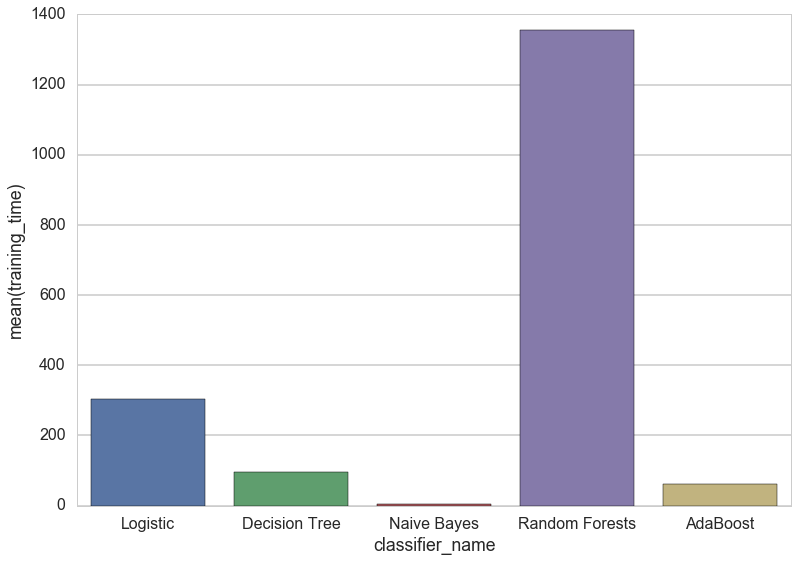

In [45]:
#plotting chart of training times
sns.barplot(x="classifier_name", y="training_time", data=score_df);